# **SketchGen**

## **1.Load the folder contents**
Use any of the below options to load the contents

1. **Access through Google Drive** (preferred method to train and create weights. Weights are saved in your drive folder) 
2. **Access through GitHub** (preferred method to work on pre trained models)


### **1.1 Load contents from Google Drive**



Place the SketchGen folder in your google drive and then run the below code.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/SketchGen/

/content/drive/MyDrive/SketchGen


### **1.2 Load contents from GitHub**

the folder will be uploaded from [SketchGen](https://github.com/sumanthreddy07/SketchGen).

In [ ]:
!git clone https://github.com/sumanthreddy07/SketchGen.git

In [ ]:
%cd SketchGen/

## **2. Training the model on a dataset(s)**

**NOTE: Skip this block if you are working on pre-trained models**

default dataset = cat

- training on a specific dataset can be made using the <code>--dataset</code> argument.
- training multiple datasets on a single model is made by editing the hyperparameters in the seq2seqVAE.py file -> <code>'data_set': ['first_dataset','second_dataset']</code>

In [1]:
#Run this code block to avoid printing tensorflow logs
import logging
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

In [ ]:
!python3 seq2seqVAE_train.py --data_set=cat

## **3. Load the weights of the model and animate the results**

We look into the models trained using [SketchGen](https://github.com/sumanthreddy07/SketchGen). We load the models, draw random sketches presented by the model travel along the latent space and explore what our model has learned.

In [1]:
#dataset used
name = "leaf"
#datasets directory 
data_dir  = 'datasets'
# Path to the experiment directory that was created during training
exp_dir = 'experiments/'+name+'/exp'
# Checkpoint file name (assumed in checkpoints folder within exp_dir)
weights_fname = name+".hdf5"

#### **Imports**

In [2]:
import os
import copy
from utils import *
from seq2seqVAE_train import *
import seq2seqVAE as sketch_rnn_model
from seq2seqVAE import sample

In [3]:
# libraries required for visualisation:
from IPython.display import SVG, display
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import svgwrite
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPM
import glob

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

- draw_strokes() function draws a SVG image from the stroke data
- make_grid_svg() function is responsible for the 2d grid of the image

- animate() function saves the list of SVG images in a folder, converts them into PNG format and creates a GIF animation. The gifs are stored in the animations folder.

In [4]:
# little function that displays vector images and saves them to .svg
def draw_strokes(data, factor=0.05, svg_filename = 'SVG/sample.svg'):
    
    if not os.path.exists(os.path.dirname(svg_filename)):
        os.makedirs(os.path.dirname(svg_filename))
    
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (100 + max_x - min_x, 100 + max_y - min_y)
    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
    lift_pen = 1
    abs_x = 50 - min_x 
    abs_y = 50 - min_y
    
    p = "M%s,%s " % (abs_x, abs_y)
    command = "m"
    for i in range(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i,0])/factor
        y = float(data[i,1])/factor
        lift_pen = data[i, 2]
        p += command+str(x)+","+str(y)+" "
    the_color = "black"
    stroke_width = 1
    dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
    dwg.save()
    display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
    def get_start_and_end(x):
        x = np.array(x)
        x = x[:, 0:2]
        x_start = x[0]
        x_end = x.sum(axis=0)
        x = x.cumsum(axis=0)
        x_max = x.max(axis=0)
        x_min = x.min(axis=0)
        center_loc = (x_max+x_min)*0.5
        return x_start-center_loc, x_end
    x_pos = 0.0
    y_pos = 0.0
    result = [[x_pos, y_pos, 1]]
    for sample in s_list:
        s = sample[0]
        grid_loc = sample[1]
        grid_y = grid_loc[0]*grid_space+grid_space*0.5
        grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
        start_loc, delta_pos = get_start_and_end(s)
    
        loc_x = start_loc[0]
        loc_y = start_loc[1]
        new_x_pos = grid_x+loc_x
        new_y_pos = grid_y+loc_y
        result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])
    
        result += s.tolist()
        result[-1][2] = 1
        x_pos = new_x_pos+delta_pos[0]
        y_pos = new_y_pos+delta_pos[1]
    return np.array(result)

In [5]:
def animate(data,name,factor=0.05,svg_filename='SVG/animate',animation_folder = 'animations/animation'):
    
    if os.path.exists(os.path.dirname(svg_filename)):
        files = glob.glob('SVG/*')
        for f in files:
            os.remove(f)
    else:
        os.makedirs(os.path.dirname(svg_filename))

    if not os.path.exists(os.path.dirname(animation_folder)):
        os.makedirs(os.path.dirname(animation_folder))

    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (100 + max_x - min_x, 100 + max_y - min_y)
    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
    lift_pen = 1
    abs_x = 50 - min_x 
    abs_y = 50 - min_y
    
    the_color = "black"
    stroke_width = 4
    p = "M%s,%s " % (abs_x, abs_y)
    command = "m"
    
    for i in range(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i,0])/factor
        y = float(data[i,1])/factor
        lift_pen = data[i, 2]

        p += command+str(x)+","+str(y)+" "
        dwg = svgwrite.Drawing(svg_filename+str(i)+'.svg', size=dims)
        dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
        dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
        dwg.save()
        drawing = svg2rlg(svg_filename+str(i)+'.svg')
        renderPM.drawToFile(drawing,svg_filename+str(i)+'.png', fmt="PNG")
        os.remove(svg_filename+str(i)+'.svg')
        
    dwg = svgwrite.Drawing(svg_filename+str(len(data))+'.svg', size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
    dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
    #display(SVG(dwg.tostring()))
    dwg.save()
    drawing = svg2rlg(svg_filename+str(len(data))+'.svg')
    renderPM.drawToFile(drawing,svg_filename+str(len(data))+'.png', fmt="PNG")
    os.remove(svg_filename+str(len(data))+'.svg')
    
    # Create the frames
    frames = []
    for i in range(len(data)+1):
        new_frame = Image.open(svg_filename+str(i)+".png")
        frames.append(new_frame)
     
    #Save into a GIF file that loops forever
    count = 0
    animation_path = animation_folder+'_'+name
    while os.path.exists(animation_path+str(count)+".gif"):
        count += 1
    animation_path = animation_path+str(count)+".gif"

    frames[0].save(animation_path, format='GIF',append_images=frames[1:],
                save_all=True, duration=150, loop=0)

#### **Load Data**

In [6]:
with open(os.path.join(exp_dir,'logs', 'model_config.json'), 'r') as f:
    model_params = json.load(f)
model_params = DotDict(model_params)   
[train_set, valid_set, test_set, hps_model] = load_dataset(data_dir, model_params)

Loaded 108285/2500/2500 from leaf.npz
Dataset combined: 113285 (108285/2500/2500), avg len 38
model_params.max_seq_len: 74
total images <= max_seq_len is 108285
total images <= max_seq_len is 2500
total images <= max_seq_len is 2500


#### **Building a Seq2seq Variational Autoencoder model**

In [7]:
weights = os.path.join(exp_dir,'checkpoints',weights_fname) # checkpoint path
seq2seq = Seq2seqModel(model_params)  # build model
seq2seq.load_trained_weights(weights) # load checkpoint
seq2seq.make_sampling_models()  # build sub models that are used to infuse inputs and probe values of intermediate layers

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 74, 5)]      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 512)          536576      encoder_input[0][0]              
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          65664       bidirectional[0][0]              
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          65664       bidirectional[0][0]              
______________________________________________________________________________________________

In [8]:
# Function for encoding input and retrieving latent vector
def encode(input_strokes, draw=False):
    strokes = to_big_strokes(input_strokes, max_len=model_params['max_seq_len']-1).tolist()
    strokes.insert(0, [0, 0, 1, 0, 0])
    seq_len = [len(input_strokes)]
    if draw:
        draw_strokes(to_normal_strokes(np.array(strokes)))
    strokes = np.expand_dims(strokes, axis=0)
    return seq2seq.sample_models['encoder_model'].predict(strokes)


In [9]:
# Function for decoding a latent space factor into a sketch
def decode(z_input=None, draw_mode=True, temperature=0.1, factor=0.05):
    z = None
    if z_input is not None:
        z = z_input
    sample_strokes, m = sample(seq2seq, seq_len=model_params.max_seq_len, temperature=temperature, z=z)
    strokes = to_normal_strokes(sample_strokes)
    if draw_mode:
        draw_strokes(strokes, factor)
    return strokes

#### **Load a random sketch from the test dataset**

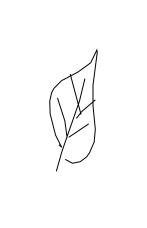

In [103]:
stroke = test_set.random_sample()
draw_strokes(stroke)

In [104]:
z = encode(stroke)

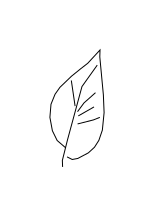

In [111]:
x = decode(z, temperature=0.5)

In [112]:
animate(x,name)

#### **Temperature of the outputs**
The temperature variable controls the level of randomness we would like our samples to have during the sampling (equation 8 of the sketch-rnn [paper](https://arxiv.org/pdf/1704.03477.pdf)).

Let's decode our model output using varying temperature values between 0.1 and 1 and see how 'creative' our model can get

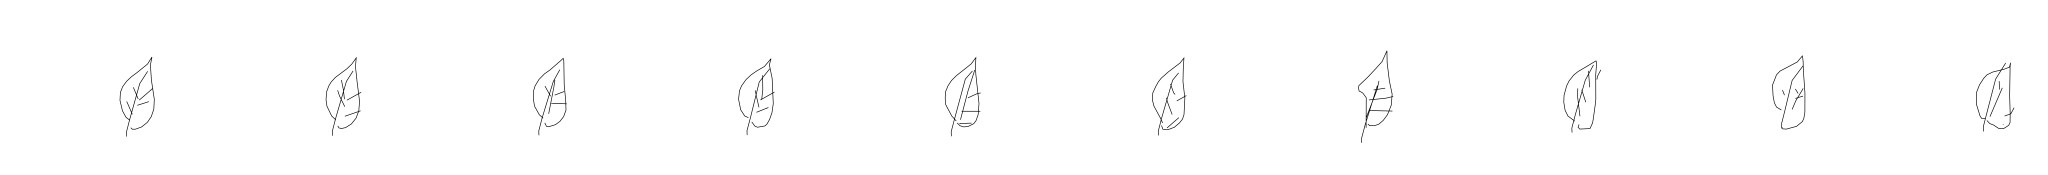

In [113]:
stroke_list = []
for i in range(10):
  stroke_list.append([decode(z, draw_mode=False, temperature=0.1*i+0.1), [0, i]])
stroke_grid = make_grid_svg(stroke_list)
draw_strokes(stroke_grid)

#### **Interpolating between two samples**
Now let's see what happens when we interpolate between two different cats!

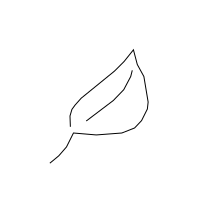

In [148]:
stroke = test_set.random_sample()
draw_strokes(stroke)
z0 = encode(stroke)

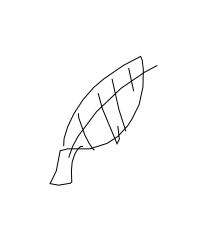

In [168]:
stroke = test_set.random_sample()
draw_strokes(stroke)
z1 = encode(stroke)

In [170]:
def interpolate_z(z_0, z_1, draw=True):
    z_list = [] # interpolate spherically between z0 and z1
    N = 10
    for t in np.linspace(0, 1, N):
        z_list.append(slerp(z_0, z_1, t))
    # for every latent vector in z_list, sample a vector image
    reconstructions = []
    for i in range(N):
        reconstructions.append([decode(np.expand_dims(z_list[i],axis=0), draw_mode=False), [0, i]])
    stroke_grid = make_grid_svg(reconstructions)
    if draw:
        draw_strokes(stroke_grid)

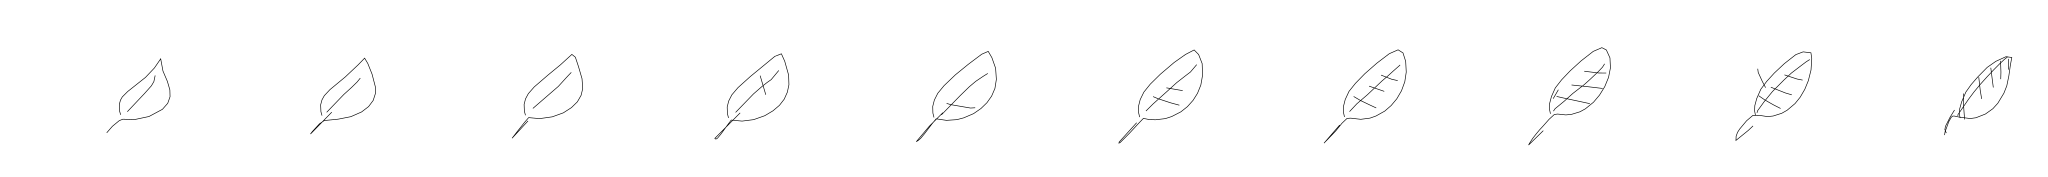

In [171]:
z1 = np.squeeze(z1)
z0 = np.squeeze(z0)

interpolate_z(z0,z1)

#### **Random Inputs**
Since this is a Variational Autoencoder, we don't need to use an actual sketch in order to generate new sketches. We can sample randomly within the latent space and feed the result to the decoder.

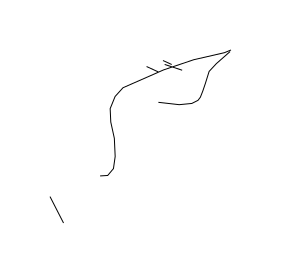

In [146]:
random_input = np.expand_dims(np.random.randn(model_params.z_size),0)
_ = decode(random_input)